In [1]:
# usual imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

In [2]:
# read in the data
data = pd.read_csv("KaggleV2-May-2016.csv", parse_dates=["AppointmentDay", "ScheduledDay"])

### Initial data cleaning 

In [3]:
# we see we have no missing values 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null datetime64[ns]
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: datetime64[ns](2), float64(1), int64(8), object(3)
memory usage: 11.8+ MB


In [4]:
# we will filter nonensical data values, such as the negative value reported for a patient's age 
data.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [5]:
# filter out negative age
data = data[data.Age >=0]

In [6]:
# this turns the no-show variable into a binary of true or false where true means a no-show  
data['no_show_bi'] = data["No-show"]== 'Yes'

In [7]:
# create a column that is the day of the week of the appointment 
data["appointment_day"] = data["AppointmentDay"].dt.weekday_name

In [8]:
# Wednesday is the most common day of the week for an appointment, and Saturday is the least common 
data["appointment_day"].value_counts()

Wednesday    25867
Tuesday      25640
Monday       22714
Friday       19019
Thursday     17247
Saturday        39
Name: appointment_day, dtype: int64

In [9]:
# remove the Saturday appointments since they are presumably outliers or false data
data= data[data["appointment_day"] != "Saturday"]

In [10]:
# create a column for the time elapsed between when a patient scheduled the appointment and the actual start time of the appointment
data["wait"] = (data["AppointmentDay"].dt.date - data["ScheduledDay"].dt.date)

In [11]:
# we will remove the 5 appointments that report a negative wait time, as this is nonsensical data 
data[data['wait'] < "0 days"]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,no_show_bi,appointment_day,wait
27033,7.839273e+12,5679978,M,2016-05-10 10:51:53,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,True,Monday,-1 days
55226,7.896294e+12,5715660,F,2016-05-18 14:50:41,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,True,Tuesday,-1 days
64175,2.425226e+13,5664962,F,2016-05-05 13:43:58,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,True,Wednesday,-1 days
71533,9.982316e+14,5686628,F,2016-05-11 13:49:20,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,True,Thursday,-6 days
72362,3.787482e+12,5655637,M,2016-05-04 06:50:57,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,Yes,True,Tuesday,-1 days


In [12]:
# drop negative wait time rows
data = data[data['wait'] >= "0 days"]

In [13]:
# neighbourhoods with fewer than 50 appointments will be treated as outliers, as this is inconsistent with the larger body of data  
data.Neighbourhood.value_counts().tail(10)

UNIVERSITÁRIO                  152
SEGURANÇA DO LAR               145
NAZARETH                       135
MORADA DE CAMBURI               96
PONTAL DE CAMBURI               69
ILHA DO BOI                     35
ILHA DO FRADE                   10
AEROPORTO                        8
ILHAS OCEÂNICAS DE TRINDADE      2
PARQUE INDUSTRIAL                1
Name: Neighbourhood, dtype: int64

In [14]:
# remove outlier neighbourhoods
remove_list = ["ILHA DO BOI", "ILHA DO FRADE", "AEROPORTO", "ILHAS OCEÂNICAS DE TRINDADE","PARQUE INDUSTRIAL"]
data= data[~data.Neighbourhood.isin(remove_list)]

## Some interesting observations

#### Though we have the time the appointment was scheduled, we do not have the actual time of the appointment. The time of appointment request does not seem to be a strikingly useful metric, but perhaps it is this way in order to maintain for patient privacy. 

In [15]:
# the no-show rate is the mean of the no_show_bi column 
# this will be used to compare the different features and how they relate to the no-show rate 
data.no_show_bi.mean()

0.2019180265517179

### The total no-show rate for the data set is 20.19% This is the base rate to compare with specific groups of patients. 
### We will now investigate the following question: Which variables appear to have a strong correlation to successful patient arrival for the scheduled appointment?

In [16]:
# the day of the week that the appointment takes place does have a slight affect upon the no-show rate
data.groupby('appointment_day')[["no_show_bi"]].mean()

,no_show_bi
appointment_day,
Friday,0.212252
Monday,0.206509
Thursday,0.193582
Tuesday,0.200897
Wednesday,0.196860


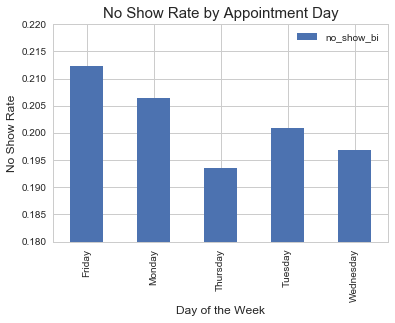

In [47]:
# the day of the week that the appointment takes place does have a slight affect upon the no-show rate
data.groupby('appointment_day')[["no_show_bi"]].mean().plot(kind="bar")
plt.ylim(.18,.22)
plt.title("No Show Rate by Appointment Day",fontsize=15)
plt.ylabel("No Show Rate",fontsize=12)
plt.xlabel("Day of the Week",fontsize=12)
#plt.show()
plt.savefig('day_of_week_plot.png') #saves the plot 

#### Wednesday and Thursday have comparably-low no-show rates, while Monday and Friday have the highest no-show rates. 

In [18]:
data.groupby('Gender')[["no_show_bi"]].mean()

,no_show_bi
Gender,
F,0.203093
M,0.199736


#### Comparing gender, females have a slightly higher rate of failing to arrive for the appointment, but the difference between the genders is not expected to be statistically significant.

In [19]:
data.Handcap.value_counts()

0    108188
1      2039
2       183
3        13
4         3
Name: Handcap, dtype: int64

#### Only about 2% of all patients have any handicap. We do see below a correlation betweeen the number of handicaps and no-show rate.  

In [20]:
data.groupby('Handcap')[["no_show_bi"]].mean()

,no_show_bi
Handcap,
0,0.202351
1,0.178519
2,0.202186
3,0.230769
4,0.333333


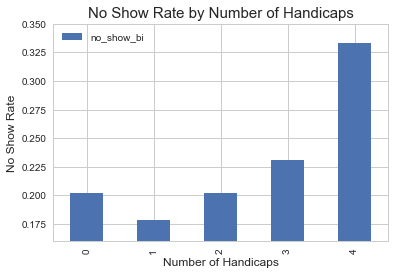

In [48]:
data.groupby('Handcap')[["no_show_bi"]].mean().plot(kind="bar")
plt.ylim(.16,.35)
plt.title("No Show Rate by Number of Handicaps",fontsize=15)
plt.ylabel("No Show Rate",fontsize=12)
plt.xlabel("Number of Handicaps",fontsize=12)
plt.show()
#plt.savefig('handicap_plot.png') #saves the plot 

In [22]:
data.groupby('SMS_received')[["no_show_bi"]].mean()

,no_show_bi
SMS_received,
0,0.166971
1,0.275814


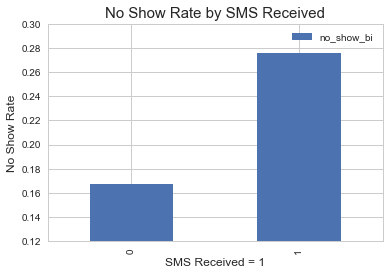

In [49]:
data.groupby('SMS_received')[["no_show_bi"]].mean().plot(kind="bar")
plt.ylim(.12,.3)
plt.title("No Show Rate by SMS Received",fontsize=15)
plt.ylabel("No Show Rate",fontsize=12)
plt.xlabel("SMS Received = 1",fontsize=12)
plt.show()
#plt.savefig('handicap_plot.png') #saves the plot 

####  We see a very strong correlation between receiving a SMS and failure to arrive for the appointment. This is somewhat counter-intuitive, unless recieving a text is something that patients opt into and thus there is self-selection bias towards patients that know they are more likely to miss their appointments. It certainly bears further investigation. 

In [24]:
# alcoholism does not significantly affect the no-show rate 
data.groupby('Alcoholism')[["no_show_bi"]].mean()

,no_show_bi
Alcoholism,
0,0.201928
1,0.201608


####  Alcoholism does not seem to affect the no-show rate. This does seem to be a surprising result. 

In [25]:
# hipertension was found to impact no-show rate   
data.groupby('Hipertension')[["no_show_bi"]].mean()

,no_show_bi
Hipertension,
0,0.209013
1,0.173035


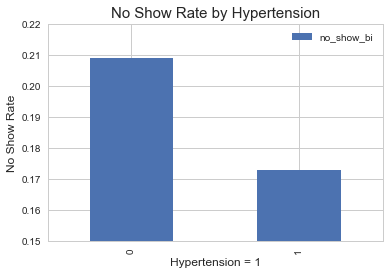

In [51]:
# hipertension was found to impact no-show rate   
data.groupby('Hipertension')[["no_show_bi"]].mean().plot(kind="bar")
plt.ylim(.15,.22)
plt.title("No Show Rate by Hypertension",fontsize=15)
plt.ylabel("No Show Rate",fontsize=12)
plt.xlabel("Hypertension = 1",fontsize=12)
plt.show()

#### Hipertension does seem to be inversely-correlated with the no-show rate, thus those with hipertension were more likely to arrive to their appointments. 

In [27]:
data.groupby('Diabetes')[["no_show_bi"]].mean()

,no_show_bi
Diabetes,
0,0.203614
1,0.180008


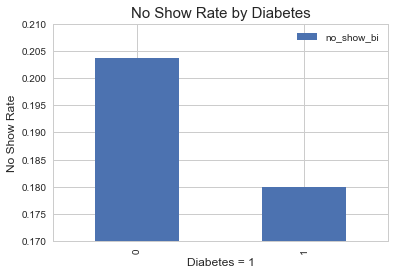

In [52]:
data.groupby('Diabetes')[["no_show_bi"]].mean().plot(kind="bar")
plt.ylim(.17,.21)
plt.title("No Show Rate by Diabetes",fontsize=15)
plt.ylabel("No Show Rate",fontsize=12)
plt.xlabel("Diabetes = 1",fontsize=12)
plt.show()

#### Diabetes was likewise inversely-correlated with the no-show rate, thus diabetic patients missed fewer appointments than patients without diabetes.

In [29]:
data.groupby('Scholarship')[["no_show_bi"]].mean()

,no_show_bi
Scholarship,
0,0.198046
1,0.237429


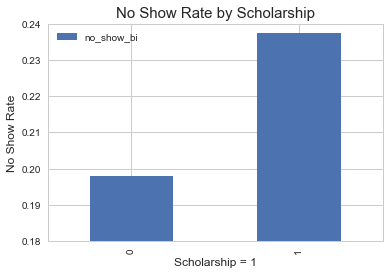

In [53]:
data.groupby('Scholarship')[["no_show_bi"]].mean().plot(kind="bar")
plt.ylim(.18,.24)
plt.title("No Show Rate by Scholarship",fontsize=15)
plt.ylabel("No Show Rate",fontsize=12)
plt.xlabel("Scholarship = 1",fontsize=12)
plt.show()

#### Scholarship recipience was correlated with a higher no-show rate. 

In [31]:
# a sample of the no-show rate from 15 of the 76 remaining neighbourhoods
data.groupby('Neighbourhood')[["no_show_bi"]].mean().head(13)

,no_show_bi
Neighbourhood,
ANDORINHAS,0.230327
ANTÔNIO HONÓRIO,0.184502
ARIOVALDO FAVALESSA,0.223827
BARRO VERMELHO,0.215130
BELA VISTA,0.201363
BENTO FERREIRA,0.224942
BOA VISTA,0.185897
BONFIM,0.198341
CARATOÍRA,0.229980


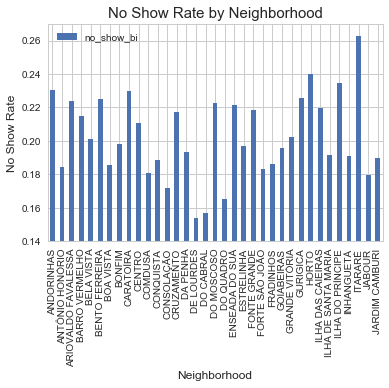

In [54]:
# a sample of the no-show rate from 15 of the 76 remaining neighbourhoods
data.groupby('Neighbourhood')[["no_show_bi"]].mean().head(35).plot(kind="bar")
plt.ylim(.14,.27)
plt.title("No Show Rate by Neighborhood",fontsize=15)
plt.ylabel("No Show Rate",fontsize=12)
plt.xlabel("Neighborhood",fontsize=12)
plt.show()

#### We can see from the above that the 76 remaining neighbourhoods report a broad range of no-show rates. The minimun no-show rate by neighbourhood is 15%, and the maximum rate is 29%.

## IMPORTANT FEATURES: So far, we have found some categorical features of our dataset that should be able to help predict whether or not a patient will no-show. The strongest indicators seem to be appointment day, handicap, hipertension, diabetes, scholarship, receipt of a text reminder, and neighbourhood. 

### We will now evaluate some continuous variables to see their effect on no-show trends. 

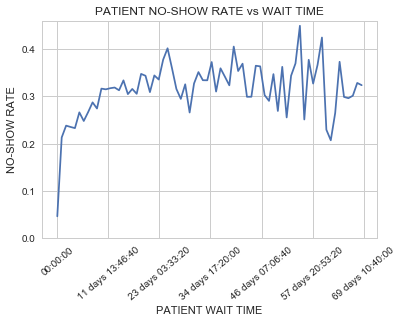

In [33]:
# create a plot of no-show rate by patient appointment wait time 
data.groupby('wait').mean().no_show_bi[:70].plot()
plt.title("PATIENT NO-SHOW RATE vs WAIT TIME")
plt.ylabel("NO-SHOW RATE")
plt.xlabel("PATIENT WAIT TIME")
plt.xticks(rotation=40)
plt.ylim(0,0.46)
plt.show()

#### The plot above indicates that the time elapsed between appointment booking and the appointment date, called 'patient wait time', is positivly correlated with no-show rates. The correlation increases sharply in the first 10 days of 'patient wait time', and levels off to a pretty consistent mid-30s percent no-show rate in the range of 11-23 days of 'patient wait time'. 

In [34]:
data.groupby('wait')[["no_show_bi"]].mean().head(5)

,no_show_bi
wait,
0 days,0.046476
1 days,0.213216
2 days,0.238223
3 days,0.235445
4 days,0.232967


#### We can clearly see above that the no-show rate for same-day appointments is very low. 

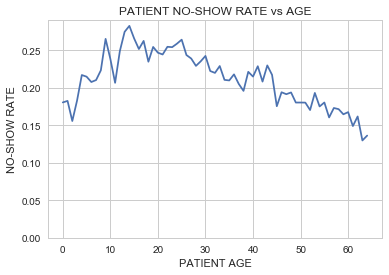

In [35]:
# create a plot of no-show rate compared to the patients age
data.groupby('Age').mean().no_show_bi[:65].plot()
plt.title("PATIENT NO-SHOW RATE vs AGE")
plt.ylabel("NO-SHOW RATE")
plt.xlabel("PATIENT AGE")
plt.ylim(0,.29)
plt.show()

#### We can see that in pateints under 20 years old, age is positivley-correlated with no-show rate. After the age of 20, patient age is negatively-correlated with no-show rate. 

## TIME SERIES PLOTS

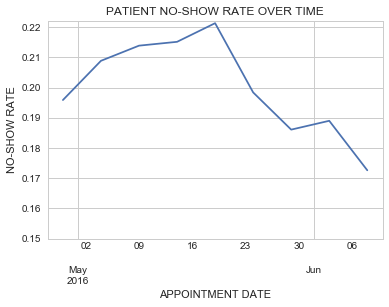

In [36]:
# create a plot of no-show rates over time, resampling every 5 days 
no_show_over_time = data.set_index('AppointmentDay').resample('5D').mean().no_show_bi.plot()
plt.title("PATIENT NO-SHOW RATE OVER TIME")
plt.ylabel("NO-SHOW RATE")
plt.xlabel("APPOINTMENT DATE")
plt.ylim(0.15,.222)
plt.show()

#### The above graph shows that the average no-show rate increased until mid-May and then decreased. This is interesting, and looking into why such a variation would exist could be enlightening.

In [37]:
data_by_month = data.set_index('AppointmentDay').resample('1M')[["no_show_bi"]].mean()
data_by_month

,no_show_bi
AppointmentDay,
2016-04-30,0.195605
2016-05-31,0.207851
2016-06-30,0.184569


#### The above shows that May, on average, had more no-shows than April or June. This is an odd observation, and it would be interesting to see if something important occured external to this data that would cause such a shift by month. Also, it would be great if we had more of a timespan to investigate if this occurs on a yearly basis or monthly cycles.  

## In Conclusion, we have shown that many of the variables from this data set can be strong indicators of the likelihood of patient no-show to an appointment with a physician. We found some variables like alcoholism and gender to be incosequential, while others, such as receiving an SMS reminder, are surprisingly highly-correlated to no-show rate. 